<a href="https://colab.research.google.com/github/Nishit1945-bot/Colour-Constancy-from-Spectral-Data/blob/main/Color_Ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%bash
mkdir -p /content/drive/MyDrive/color_con
rsync -a /content/color_con/ /content/drive/MyDrive/color_con/


In [ ]:
%%bash
rm -rf /content/color_con
ln -s /content/drive/MyDrive/color_con /content/color_con
ls -ld /content/color_con


lrwxrwxrwx 1 root root 32 Oct  4 11:37 /content/color_con -> /content/drive/MyDrive/color_con


In [ ]:
ls -R /content/color_con | head -n 50


/content/color_con@


In [ ]:
%%bash
set -e
mkdir -p /content/color_con/configs
mkdir -p /content/color_con/data/raw/spd_patches
mkdir -p /content/color_con/data/clean/spd_patches
mkdir -p /content/color_con/outputs
mkdir -p /content/color_con/src/cc/utils
mkdir -p /content/color_con/src/cc/dataio
mkdir -p /content/color_con/src/cc/models
mkdir -p /content/color_con/src/cc/train
mkdir -p /content/color_con/src/cc/eval
mkdir -p /content/color_con/scripts
mkdir -p /content/color_con/tests

# package markers
touch /content/color_con/src/cc/__init__.py
touch /content/color_con/src/cc/utils/__init__.py
touch /content/color_con/src/cc/dataio/__init__.py
touch /content/color_con/src/cc/models/__init__.py
touch /content/color_con/src/cc/train/__init__.py
touch /content/color_con/src/cc/eval/__init__.py

echo "Project created at /content/color_con"


Project created at /content/color_con


In [ ]:
from pathlib import Path
paths = [
    "/content/color_con",
    "/content/color_con/configs",
    "/content/color_con/data/raw/spd_patches",
    "/content/color_con/data/clean/spd_patches",
    "/content/color_con/outputs",
    "/content/color_con/src/cc/utils",
    "/content/color_con/src/cc/dataio",
    "/content/color_con/src/cc/models",
    "/content/color_con/src/cc/train",
    "/content/color_con/src/cc/eval",
    "/content/color_con/scripts",
    "/content/color_con/tests",
]
for p in paths:
    print(Path(p), "exists:", Path(p).exists())


/content/color_con exists: True
/content/color_con/configs exists: True
/content/color_con/data/raw/spd_patches exists: True
/content/color_con/data/clean/spd_patches exists: True
/content/color_con/outputs exists: True
/content/color_con/src/cc/utils exists: True
/content/color_con/src/cc/dataio exists: True
/content/color_con/src/cc/models exists: True
/content/color_con/src/cc/train exists: True
/content/color_con/src/cc/eval exists: True
/content/color_con/scripts exists: True
/content/color_con/tests exists: True


In [ ]:
!pip -q install numpy pandas scikit-learn matplotlib tqdm pyyaml
import torch
print("torch", torch.__version__, "| cuda available:", torch.cuda.is_available())


torch 2.8.0+cu126 | cuda available: True


In [ ]:
%%writefile /content/color_con/configs/default.yaml
data:
  raw_dir:   /content/color_con/data/raw/spd_patches
  clean_dir: /content/color_con/data/clean/spd_patches
  wavelengths: {start: 380, end: 780, step: 5}
  normalization: area      # none|max|area|l2
  log_transform: false

synthetic:
  n_surfaces: 12
  n_illuminants: 6
  planck_T_range: [3000, 9500]
  seed: 42
  out_npz: /content/color_con/data/clean/synthetic.npz

train:
  batch_size: 128
  epochs: 40
  lr: 1.0e-3
  weight_decay: 1.0e-4
  temperature: 0.1
  seed: 42
  device: auto   # cpu|cuda|auto

model:
  hidden_sizes: [256, 256]
  embedding_dim: 128
  projection_dim: 64

eval:
  recall_k: 5
  out_dir: /content/color_con/outputs

Overwriting /content/color_con/configs/default.yaml


In [ ]:
%%writefile /content/color_con/src/cc/utils/config.py
from pathlib import Path
import yaml, random, numpy as np, torch

def load_config(path: str) -> dict:
    """Read a YAML config file into a dict."""
    with open(path, "r") as f:
        return yaml.safe_load(f)

def set_seed(seed: int):
    """Set seeds for reproducibility (numpy + torch)."""
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)

def get_device(pref: str = "auto"):
    """Return torch.device based on preference and availability."""
    if pref == "cpu":  return torch.device("cpu")
    if pref == "cuda": return torch.device("cuda")
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")


Overwriting /content/color_con/src/cc/utils/config.py


In [ ]:
import sys
sys.path.append('/content/color_con/src')

# quick sanity check
from cc.utils.config import load_config, get_device, set_seed
cfg = load_config('/content/color_con/configs/default.yaml')
print("Loaded keys:", list(cfg.keys())[:3])
print("Device:", get_device(cfg["train"]["device"]))
set_seed(cfg["train"]["seed"])
print("Seed set OK")


Loaded keys: ['data', 'synthetic', 'train']
Device: cuda
Seed set OK


In [ ]:
%%writefile /content/color_con/src/cc/dataio/spectra.py
import numpy as np

def wavelength_grid(start: int, end: int, step: int) -> np.ndarray:
    """Make a uniform wavelength grid in nanometers (inclusive of end)."""
    return np.arange(start, end + 1e-9, step, dtype=float)

def normalize(v: np.ndarray, mode: str = "area") -> np.ndarray:
    """Normalize a spectrum by area/max/L2 (or leave unchanged)."""
    v = np.asarray(v, float)
    if mode == "none": return v
    if mode == "max":  return v / (np.max(np.abs(v)) + 1e-12)
    if mode == "area": return v / (np.trapz(np.abs(v)) + 1e-12)
    if mode == "l2":   return v / (np.linalg.norm(v) + 1e-12)
    raise ValueError(f"Unknown normalization: {mode}")

def resample_linear(w_nm: np.ndarray, v: np.ndarray, target_w: np.ndarray) -> np.ndarray:
    """Linearly resample v(w) from wavelengths w_nm onto target_w."""
    w_nm = np.asarray(w_nm, float); v = np.asarray(v, float)
    return np.interp(target_w, w_nm, v, left=v[0], right=v[-1])

def radiance_from_reflectance_illuminant(R: np.ndarray, E: np.ndarray) -> np.ndarray:
    r"""Physical relation:
        L(λ) = R(λ) · E(λ)
    Returns the (unnormalized) radiance spectrum."""
    return np.asarray(R, float) * np.asarray(E, float)


Overwriting /content/color_con/src/cc/dataio/spectra.py


In [ ]:
import numpy as np
from cc.dataio.spectra import wavelength_grid, normalize, resample_linear, radiance_from_reflectance_illuminant

# Build a grid and toy spectra
w = wavelength_grid(380, 780, 5)
R = np.linspace(0.2, 1.0, len(w))                 # toy reflectance
E = np.exp(-0.5*((w-550)/60)**2)                  # toy illuminant (Gaussian-shaped)

# Prove L(λ)=R(λ)·E(λ)
L = radiance_from_reflectance_illuminant(R, E)
print("L equals R*E:", np.allclose(L, R*E))

# Normalization checks
L_area = normalize(L, "area"); a = np.trapz(np.abs(L_area), w)
L_l2   = normalize(L, "l2");   l2 = np.linalg.norm(L_l2)
L_max  = normalize(L, "max");  m  = np.max(np.abs(L_max))
print(f"area≈1: {a:.6f} | l2≈1: {l2:.6f} | max≈1: {m:.6f}")

# Resampling check (coarse->fine)
w_coarse = np.array([380, 500, 620, 740, 780], float)
v_coarse = np.sin(w_coarse/100.0) + 2.0
v_resamp = resample_linear(w_coarse, v_coarse, w)
print("resampled length equals target grid:", len(v_resamp) == len(w))


L equals R*E: True
area≈1: 5.000000 | l2≈1: 1.000000 | max≈1: 1.000000
resampled length equals target grid: True


/tmp/ipython-input-1277554650.py:14: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  L_area = normalize(L, "area"); a = np.trapz(np.abs(L_area), w)


In [ ]:
%%writefile /content/color_con/src/cc/dataio/transforms.py
import numpy as np
# be tolerant to how the module is imported
try:
    from .spectra import normalize
except Exception:  # fallback if relative import fails
    from cc.dataio.spectra import normalize

class SpectralAugment:
    """Creates two contrastive views via gain, noise, and spectral tilt.
    Re-normalizes at the end to keep scale comparable.
    """
    def __init__(self, norm_mode: str = "area",
                 noise_std: float = 0.01,
                 tilt_std: float = 0.006,
                 gain_lnstd: float = 0.10):
        self.norm_mode = norm_mode
        self.noise_std = noise_std
        self.tilt_std  = tilt_std
        self.gain_lnstd = gain_lnstd

    def __call__(self, x: np.ndarray) -> np.ndarray:
        v = x.astype(float).copy()
        # multiplicative gain (log-normal)
        v *= np.exp(np.random.normal(0.0, self.gain_lnstd))
        # additive noise
        v += np.random.normal(0.0, self.noise_std, size=v.shape)
        # linear spectral tilt
        idx = np.linspace(-1.0, 1.0, len(v))
        v *= (1.0 + np.random.normal(0.0, self.tilt_std) * idx)
        # re-normalize
        return normalize(v, self.norm_mode).astype("float32")


Overwriting /content/color_con/src/cc/dataio/transforms.py


In [ ]:
!ls -l /content/color_con/src/cc/dataio/
!sed -n '1,120p' /content/color_con/src/cc/dataio/transforms.py


total 11
-rw------- 1 root root 1660 Oct  2 09:51 dataset.py
-rw------- 1 root root    0 Oct  4 11:37 __init__.py
drwx------ 2 root root 4096 Oct  4 11:37 __pycache__
-rw------- 1 root root 1198 Oct  4 11:37 spectra.py
-rw------- 1 root root 1919 Oct  2 09:52 synthetic.py
-rw------- 1 root root 1186 Oct  4 11:37 transforms.py
import numpy as np
# be tolerant to how the module is imported
try:
    from .spectra import normalize
except Exception:  # fallback if relative import fails
    from cc.dataio.spectra import normalize

class SpectralAugment:
    """Creates two contrastive views via gain, noise, and spectral tilt.
    Re-normalizes at the end to keep scale comparable.
    """
    def __init__(self, norm_mode: str = "area",
                 noise_std: float = 0.01,
                 tilt_std: float = 0.006,
                 gain_lnstd: float = 0.10):
        self.norm_mode = norm_mode
        self.noise_std = noise_std
        self.tilt_std  = tilt_std
        self.gain_lnstd = gain

In [ ]:
import sys, importlib, numpy as np
sys.path.append('/content/color_con/src')
try:
    aug_mod = importlib.import_module('cc.dataio.transforms')
    print("Imported:", aug_mod.__name__)
    Aug = aug_mod.SpectralAugment
    aug = Aug(norm_mode="area")
    x = np.linspace(0.1, 1.0, 81).astype("float32")
    a1, a2 = aug(x), aug(x)
    print("Different views:", not np.allclose(a1, a2))
    print("OK length:", len(a1)==len(x)==len(a2))
except Exception as e:
    import traceback; traceback.print_exc()


Imported: cc.dataio.transforms
Different views: True
OK length: True


In [ ]:
%%writefile /content/color_con/scripts/preclean_autodetect.py
from pathlib import Path
import argparse, pandas as pd, numpy as np, sys
sys.path.append(str(Path(__file__).resolve().parents[1] / "src"))
from cc.utils.config import load_config
from cc.dataio.spectra import wavelength_grid, resample_linear, normalize

def is_wavelength_vec(x: np.ndarray) -> bool:
    x = pd.to_numeric(pd.Series(x), errors='coerce').dropna().to_numpy()
    if x.size < 10: return False
    lo, hi = float(np.nanmin(x)), float(np.nanmax(x))
    if not (300 <= lo <= 480 and 600 <= hi <= 900):
        return False
    diffs = np.diff(x)
    return (np.mean(diffs > 0) > 0.9)

def load_numeric_matrix(fp: Path) -> pd.DataFrame:
    df = pd.read_csv(fp, header=None, sep=None, engine="python")
    df = df.dropna(axis=0, how='all').dropna(axis=1, how='all')
    return df

def find_wavelengths(df: pd.DataFrame):
    arr = df.apply(pd.to_numeric, errors='coerce')
    # try columns
    for c in range(arr.shape[1]):
        col = arr.iloc[:, c].to_numpy()
        if is_wavelength_vec(col):
            vals = []
            for j in range(arr.shape[1]):
                if j == c: continue
                v = arr.iloc[:, j].to_numpy()
                if np.isfinite(v).sum() >= 5: vals.append(v)
            if not vals: return None
            V = np.nanmean(np.stack(vals, axis=1), axis=1)
            wl = arr.iloc[:, c].to_numpy()
            return ("column", wl, V)
    # try rows
    for r in range(arr.shape[0]):
        row = arr.iloc[r, :].to_numpy()
        if is_wavelength_vec(row):
            vals = []
            for i in range(arr.shape[0]):
                if i == r: continue
                v = arr.iloc[i, :].to_numpy()
                if np.isfinite(v).sum() >= 5: vals.append(v)
            if not vals: return None
            V = np.nanmean(np.stack(vals, axis=0), axis=0)
            wl = arr.iloc[r, :].to_numpy()
            return ("row", wl, V)
    return None

def clean_file(fp: Path, grid: np.ndarray, norm_mode: str) -> pd.DataFrame:
    df = load_numeric_matrix(fp)
    found = find_wavelengths(df)
    if found is None:
        dfT = df.T
        found = find_wavelengths(dfT)
        if found is None:
            raise ValueError("Could not locate wavelength vector in rows or columns.")
    orient, wl, V = found
    wl = pd.to_numeric(pd.Series(wl), errors='coerce').to_numpy()
    V  = pd.to_numeric(pd.Series(V),  errors='coerce').to_numpy()
    m = np.isfinite(wl) & np.isfinite(V)
    wl, V = wl[m], V[m]
    order = np.argsort(wl); wl, V = wl[order], V[order]
    uw, idx = np.unique(wl, return_index=True); wl, V = uw, V[idx]
    V = resample_linear(wl, V, grid)
    V = normalize(V, norm_mode)
    return pd.DataFrame({"wavelength_nm": grid, "radiance": V})

def main(cfg_path: str):
    cfg = load_config(cfg_path)
    raw_dir   = Path(cfg["data"]["raw_dir"])
    clean_dir = Path(cfg["data"]["clean_dir"]); clean_dir.mkdir(parents=True, exist_ok=True)
    grid = wavelength_grid(**cfg["data"]["wavelengths"])
    norm = cfg["data"]["normalization"]
    files = sorted(raw_dir.glob("*.csv"))
    if not files:
        print(f"No CSVs found in {raw_dir}"); return
    for fp in files:
        try:
            out = clean_file(fp, grid, norm)
            out.to_csv(clean_dir/fp.name, index=False)
            print(f"[OK] {fp.name} → {clean_dir/fp.name}")
        except Exception as e:
            print(f"[FAIL] {fp.name}: {e}")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--config", default="/content/color_con/configs/default.yaml")
    args = ap.parse_args(); main(args.config)


Overwriting /content/color_con/scripts/preclean_autodetect.py


In [ ]:
!python /content/color_con/scripts/preclean_autodetect.py --config /content/color_con/configs/default.yaml

import glob, pandas as pd
cleaned = sorted(glob.glob('/content/color_con/data/clean/spd_patches/*.csv'))
print("Cleaned files:", len(cleaned))
for fp in cleaned[:3]:
    print("—", fp); display(pd.read_csv(fp).head())


/content/color_con/scripts/preclean_autodetect.py:33: RuntimeWarning: Mean of empty slice
  V = np.nanmean(np.stack(vals, axis=1), axis=1)
[OK] BluePatch.csv → /content/color_con/data/clean/spd_patches/BluePatch.csv
/content/color_con/scripts/preclean_autodetect.py:33: RuntimeWarning: Mean of empty slice
  V = np.nanmean(np.stack(vals, axis=1), axis=1)
[OK] BrownPatch.csv → /content/color_con/data/clean/spd_patches/BrownPatch.csv
/content/color_con/scripts/preclean_autodetect.py:33: RuntimeWarning: Mean of empty slice
  V = np.nanmean(np.stack(vals, axis=1), axis=1)
[OK] GreenPatch.csv → /content/color_con/data/clean/spd_patches/GreenPatch.csv
/content/color_con/scripts/preclean_autodetect.py:33: RuntimeWarning: Mean of empty slice
  V = np.nanmean(np.stack(vals, axis=1), axis=1)
[OK] OrangePatch.csv → /content/color_con/data/clean/spd_patches/OrangePatch.csv
/content/color_con/scripts/preclean_autodetect.py:33: RuntimeWarning: Mean of empty slice
  V = np.nanmean(np.stack(vals, axis=1

,wavelength_nm,radiance
0,380.0,4.328739e-07
1,385.0,8.626559e-06
2,390.0,1.130943e-05
3,395.0,5.644010e-05
4,400.0,2.552529e-04


— /content/color_con/data/clean/spd_patches/BrownPatch.csv


,wavelength_nm,radiance
0,380.0,6.223725e-05
1,385.0,1.040134e-05
2,390.0,4.813759e-07
3,395.0,1.009337e-06
4,400.0,5.792039e-05


— /content/color_con/data/clean/spd_patches/GreenPatch.csv


,wavelength_nm,radiance
0,380.0,8.181585e-07
1,385.0,3.253727e-05
2,390.0,5.627418e-05
3,395.0,1.380419e-04
4,400.0,4.382992e-04


In [ ]:
%%writefile /content/color_con/src/cc/dataio/dataset.py
from pathlib import Path
import pandas as pd, numpy as np, torch
from torch.utils.data import Dataset
from .spectra import wavelength_grid, resample_linear, normalize

class CleanedSpectraDataset(Dataset):
    """
    Loads cleaned CSVs with columns: wavelength_nm, radiance.
    Returns two augmented views (for SimCLR) + integer label.
    """
    def __init__(self, clean_dir: str, w_cfg: dict, norm: str, augment):
        self.paths = sorted(Path(clean_dir).glob("*.csv"))
        if not self.paths:
            raise FileNotFoundError(f"No CSVs in {clean_dir}")
        self.w = wavelength_grid(**w_cfg)
        self.norm = norm
        self.augment = augment
        self.labels, self.spectra = [], []
        for p in self.paths:
            df = pd.read_csv(p)
            wl  = pd.to_numeric(df["wavelength_nm"], errors="coerce").to_numpy()
            val = pd.to_numeric(df["radiance"],       errors="coerce").to_numpy()
            m = np.isfinite(wl) & np.isfinite(val)
            val = resample_linear(wl[m], val[m], self.w)
            val = normalize(val, norm)
            self.spectra.append(val.astype("float32"))
            self.labels.append(p.stem)
        self.spectra = np.stack(self.spectra)
        uniq = sorted(set(self.labels))
        self.lab2idx = {u:i for i,u in enumerate(uniq)}
        self.y = np.array([self.lab2idx[s] for s in self.labels], dtype=int)

    def __len__(self): return len(self.spectra)

    def __getitem__(self, i):
        x = self.spectra[i]
        x1 = self.augment(x)
        x2 = self.augment(x)
        return torch.from_numpy(x1), torch.from_numpy(x2), torch.tensor(self.y[i], dtype=torch.long)


Overwriting /content/color_con/src/cc/dataio/dataset.py


In [ ]:
import sys, numpy as np
sys.path.append('/content/color_con/src')

from cc.utils.config import load_config
from cc.dataio.transforms import SpectralAugment
from cc.dataio.dataset import CleanedSpectraDataset

cfg = load_config('/content/color_con/configs/default.yaml')
aug = SpectralAugment(norm_mode=cfg["data"]["normalization"])

ds = CleanedSpectraDataset(
    clean_dir=cfg["data"]["clean_dir"],
    w_cfg=cfg["data"]["wavelengths"],
    norm=cfg["data"]["normalization"],
    augment=aug
)

x1, x2, y = ds[0]
print("dataset size:", len(ds))
print("one item shapes:", x1.shape, x2.shape, "| label:", y.item())
print("labels found:", sorted(set(ds.y.tolist())))


dataset size: 8
one item shapes: torch.Size([81]) torch.Size([81]) | label: 0
labels found: [0, 1, 2, 3, 4, 5, 6, 7]


In [ ]:
%%writefile /content/color_con/src/cc/models/encoders.py
import torch, torch.nn as nn, torch.nn.functional as F

class SpectralMLP(nn.Module):
    def __init__(self, in_dim: int, hidden=(256,256), emb=128, proj=64):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hidden[0]), nn.ReLU(True),
            nn.Linear(hidden[0], hidden[1]), nn.ReLU(True),
            nn.Linear(hidden[1], emb)
        )
        self.projector = nn.Sequential(
            nn.Linear(emb, emb), nn.ReLU(True),
            nn.Linear(emb, proj)
        )
    def encode(self, x):  # returns representation z
        return self.encoder(x)
    def forward(self, x):  # returns (z, p) where p is contrastive projection
        z = self.encoder(x)
        p = F.normalize(self.projector(z), dim=-1)
        return z, p


Overwriting /content/color_con/src/cc/models/encoders.py


In [ ]:
%%writefile /content/color_con/src/cc/models/losses.py
import torch, torch.nn as nn, torch.nn.functional as F

class NTXentLoss(nn.Module):
    r"""InfoNCE / NT-Xent.
    For B pairs, stack projections to Z∈R^{2B×D}. Similarity s(a,b)=z_a·z_b / τ.
    Loss = cross_entropy(similarity_matrix, index_of_positive).
    """
    def __init__(self, temperature: float = 0.1):
        super().__init__()
        self.t = float(temperature)
    def forward(self, p1: torch.Tensor, p2: torch.Tensor) -> torch.Tensor:
        p1 = F.normalize(p1, dim=-1); p2 = F.normalize(p2, dim=-1)
        B = p1.size(0)
        Z = torch.cat([p1, p2], dim=0)              # [2B,D]
        S = (Z @ Z.t()) / self.t                    # cosine sims / τ
        S.fill_diagonal_(-9e15)                     # mask self
        pos = torch.cat([torch.arange(B, 2*B), torch.arange(0, B)], dim=0).to(S.device)
        return F.cross_entropy(S, pos)


Overwriting /content/color_con/src/cc/models/losses.py


In [ ]:
import sys, torch
sys.path.append('/content/color_con/src')

from cc.utils.config import load_config
from cc.dataio.transforms import SpectralAugment
from cc.dataio.dataset import CleanedSpectraDataset
from cc.models.encoders import SpectralMLP
from cc.models.losses import NTXentLoss

cfg = load_config('/content/color_con/configs/default.yaml')
aug = SpectralAugment(norm_mode=cfg["data"]["normalization"])
ds  = CleanedSpectraDataset(cfg["data"]["clean_dir"], cfg["data"]["wavelengths"], cfg["data"]["normalization"], aug)

in_dim = len(ds.spectra[0])
model  = SpectralMLP(in_dim, hidden=tuple(cfg["model"]["hidden_sizes"]),
                     emb=cfg["model"]["embedding_dim"], proj=cfg["model"]["projection_dim"])
loss_fn = NTXentLoss(cfg["train"]["temperature"])

x1, x2, _ = zip(*[ds[i] for i in range(min(8, len(ds)))])  # small batch
x1 = torch.stack(list(x1)).float(); x2 = torch.stack(list(x2)).float()
_, p1 = model(x1); _, p2 = model(x2)
print("projections:", p1.shape, p2.shape, "| loss:", float(loss_fn(p1, p2)))


projections: torch.Size([8, 64]) torch.Size([8, 64]) | loss: 2.7080466747283936


/tmp/ipython-input-3951609217.py:22: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print("projections:", p1.shape, p2.shape, "| loss:", float(loss_fn(p1, p2)))


In [ ]:
%%writefile /content/color_con/src/cc/train/simclr_trainer.py
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from cc.utils.config import get_device
from cc.models.encoders import SpectralMLP
from cc.models.losses import NTXentLoss

class SimCLRTrainer:
    def __init__(self, in_dim: int, cfg: dict):
        self.cfg = cfg
        self.device = get_device(cfg["train"].get("device","auto"))
        hs = tuple(cfg["model"]["hidden_sizes"])
        self.model = SpectralMLP(in_dim, hidden=hs,
                                 emb=cfg["model"]["embedding_dim"],
                                 proj=cfg["model"]["projection_dim"]).to(self.device)
        self.criterion = NTXentLoss(cfg["train"]["temperature"])
        self.opt = torch.optim.AdamW(self.model.parameters(),
                                     lr=cfg["train"]["lr"],
                                     weight_decay=cfg["train"]["weight_decay"])

    def fit(self, dataset):
        loader = DataLoader(dataset, batch_size=self.cfg["train"]["batch_size"], shuffle=True, drop_last=True)
        losses = []
        for ep in range(self.cfg["train"]["epochs"]):
            self.model.train(); total = 0.0
            for x1, x2, _ in tqdm(loader, desc=f"Epoch {ep+1}/{self.cfg['train']['epochs']}"):
                x1, x2 = x1.to(self.device), x2.to(self.device)
                _, p1 = self.model(x1); _, p2 = self.model(x2)
                loss = self.criterion(p1, p2)
                self.opt.zero_grad(); loss.backward(); self.opt.step()
                total += loss.item()
            losses.append(total/len(loader))
        return losses

    def save(self, out_dir: str, losses):
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        torch.save(self.model.state_dict(), Path(out_dir)/"simclr_mlp.pt")
        plt.figure(); plt.plot(losses); plt.xlabel("epoch"); plt.ylabel("InfoNCE loss"); plt.tight_layout()
        plt.savefig(Path(out_dir)/"training_loss.png", dpi=150); plt.close()


Overwriting /content/color_con/src/cc/train/simclr_trainer.py


In [ ]:
%%writefile /content/color_con/src/cc/train/simclr_trainer.py
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from cc.utils.config import get_device
from cc.models.encoders import SpectralMLP
from cc.models.losses import NTXentLoss

class SimCLRTrainer:
    def __init__(self, in_dim: int, cfg: dict):
        self.cfg = cfg
        self.device = get_device(cfg["train"].get("device","auto"))
        hs = tuple(cfg["model"]["hidden_sizes"])
        self.model = SpectralMLP(in_dim, hidden=hs,
                                 emb=cfg["model"]["embedding_dim"],
                                 proj=cfg["model"]["projection_dim"]).to(self.device)
        self.criterion = NTXentLoss(cfg["train"]["temperature"])
        self.opt = torch.optim.AdamW(self.model.parameters(),
                                     lr=cfg["train"]["lr"],
                                     weight_decay=cfg["train"]["weight_decay"])

    def fit(self, dataset):
        # pick a safe batch size for small datasets
        bs = min(self.cfg["train"]["batch_size"], len(dataset))
        if bs < 2:
            raise ValueError(f"Batch size must be ≥2 for InfoNCE, got {bs}.")
        loader = DataLoader(dataset, batch_size=bs, shuffle=True, drop_last=False)
        losses = []
        for ep in range(self.cfg["train"]["epochs"]):
            self.model.train(); total = 0.0; steps = 0
            for x1, x2, _ in tqdm(loader, desc=f"Epoch {ep+1}/{self.cfg['train']['epochs']}"):
                x1, x2 = x1.to(self.device), x2.to(self.device)
                _, p1 = self.model(x1); _, p2 = self.model(x2)
                loss = self.criterion(p1, p2)
                self.opt.zero_grad(); loss.backward(); self.opt.step()
                total += loss.item(); steps += 1
            losses.append(total / max(1, steps))
        return losses

    def save(self, out_dir: str, losses):
        Path(out_dir).mkdir(parents=True, exist_ok=True)
        torch.save(self.model.state_dict(), Path(out_dir)/"simclr_mlp.pt")
        plt.figure(); plt.plot(losses); plt.xlabel("epoch"); plt.ylabel("InfoNCE loss"); plt.tight_layout()
        plt.savefig(Path(out_dir)/"training_loss.png", dpi=150); plt.close()


Overwriting /content/color_con/src/cc/train/simclr_trainer.py


In [ ]:
!python /content/color_con/scripts/train_simclr.py --config /content/color_con/configs/default.yaml


Epoch 1/40: 100% 1/1 [00:00<00:00,  1.18it/s]
Epoch 2/40: 100% 1/1 [00:00<00:00, 110.84it/s]
Epoch 3/40: 100% 1/1 [00:00<00:00, 142.72it/s]
Epoch 4/40: 100% 1/1 [00:00<00:00, 135.16it/s]
Epoch 5/40: 100% 1/1 [00:00<00:00, 155.07it/s]
Epoch 6/40: 100% 1/1 [00:00<00:00, 160.12it/s]
Epoch 7/40: 100% 1/1 [00:00<00:00, 160.25it/s]
Epoch 8/40: 100% 1/1 [00:00<00:00, 154.85it/s]
Epoch 9/40: 100% 1/1 [00:00<00:00, 162.72it/s]
Epoch 10/40: 100% 1/1 [00:00<00:00, 164.92it/s]
Epoch 11/40: 100% 1/1 [00:00<00:00, 161.32it/s]
Epoch 12/40: 100% 1/1 [00:00<00:00, 134.51it/s]
Epoch 13/40: 100% 1/1 [00:00<00:00, 156.50it/s]
Epoch 14/40: 100% 1/1 [00:00<00:00, 162.37it/s]
Epoch 15/40: 100% 1/1 [00:00<00:00, 164.07it/s]
Epoch 16/40: 100% 1/1 [00:00<00:00, 163.45it/s]
Epoch 17/40: 100% 1/1 [00:00<00:00, 146.52it/s]
Epoch 18/40: 100% 1/1 [00:00<00:00, 149.81it/s]
Epoch 19/40: 100% 1/1 [00:00<00:00, 149.59it/s]
Epoch 20/40: 100% 1/1 [00:00<00:00, 156.48it/s]
Epoch 21/40: 100% 1/1 [00:00<00:00, 153.79it/s]
Ep

In [ ]:
%%writefile /content/color_con/src/cc/eval/metrics.py
import numpy as np, torch
from sklearn.metrics.pairwise import cosine_distances
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def embed_all(model, X: np.ndarray, device) -> np.ndarray:
    model.eval(); Z=[]
    with torch.no_grad():
        for i in range(0, len(X), 1024):
            xb = torch.from_numpy(X[i:i+1024]).to(device)
            zb = model.encode(xb).cpu().numpy(); Z.append(zb)
    return np.vstack(Z)

def recall_at_k(Z, y, k=5):
    D = cosine_distances(Z,Z); np.fill_diagonal(D, np.inf)
    idx = np.argsort(D, axis=1)[:, :k]
    hits = sum(y[i] in y[idx[i]] for i in range(len(y)))
    return hits/len(y)

def intra_inter_ratio(Z, y):
    D = cosine_distances(Z,Z)
    intra = D[y[:,None]==y[None,:]]; inter = D[y[:,None]!=y[None,:]]
    return float(np.mean(intra)/(np.mean(inter)+1e-12))

def leakage_probe(encoder, augment, X, device, cap=2000):
    # build two augmented views per sample; chance ≈ 0.5 if leakage is low
    X_aug, lbl = [], []; n = min(len(X), cap)
    for i in range(n): X_aug += [augment(X[i]), augment(X[i])]; lbl += [0,1]
    Z = embed_all(encoder, np.stack(X_aug), device)
    clf = LogisticRegression(max_iter=1000).fit(Z[:n], lbl[:n])
    pred = clf.predict(Z[n:])
    return accuracy_score(lbl[n:], pred)

def tsne_plot(Z, y, out_path):
    ts = TSNE(n_components=2, init='random', learning_rate='auto',
              perplexity=max(2, min(30, len(Z)//3)))
    Y = ts.fit_transform(Z)
    plt.figure(figsize=(5,4))
    for c in np.unique(y):
        m = (y==c); plt.scatter(Y[m,0], Y[m,1], s=18, label=str(c))
    plt.legend(title="surface", bbox_to_anchor=(1.05,1), loc="upper left")
    plt.title("t-SNE of embeddings")
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close()


Overwriting /content/color_con/src/cc/eval/metrics.py


In [ ]:
%%writefile /content/color_con/scripts/evaluate.py
from pathlib import Path
import argparse, numpy as np, pandas as pd, torch, sys
sys.path.append(str(Path(__file__).resolve().parents[1] / "src"))
from cc.utils.config import load_config, get_device
from cc.dataio.transforms import SpectralAugment
from cc.dataio.dataset import CleanedSpectraDataset
from cc.dataio.spectra import wavelength_grid
from cc.models.encoders import SpectralMLP
from cc.eval.metrics import embed_all, recall_at_k, intra_inter_ratio, leakage_probe, tsne_plot

def main(cfg_path):
    cfg = load_config(cfg_path)
    device = get_device(cfg["train"]["device"])
    aug = SpectralAugment(norm_mode=cfg["data"]["normalization"])
    ds  = CleanedSpectraDataset(cfg["data"]["clean_dir"], cfg["data"]["wavelengths"], cfg["data"]["normalization"], aug)
    in_dim = len(wavelength_grid(**cfg["data"]["wavelengths"]))
    model = SpectralMLP(in_dim, hidden=tuple(cfg["model"]["hidden_sizes"]),
                        emb=cfg["model"]["embedding_dim"], proj=cfg["model"]["projection_dim"]).to(device)
    model.load_state_dict(torch.load(Path(cfg["eval"]["out_dir"])/"simclr_mlp.pt", map_location=device))
    X = ds.spectra.astype("float32"); y = ds.y
    Z = embed_all(model, X, device)
    r5  = recall_at_k(Z,y, k=cfg["eval"]["recall_k"])
    rho = intra_inter_ratio(Z,y)
    leak= leakage_probe(model, aug, X, device)
    out = Path(cfg["eval"]["out_dir"]); out.mkdir(parents=True, exist_ok=True)
    (out/"metrics.txt").write_text(
        f"Recall@{cfg['eval']['recall_k']}: {r5:.3f}\n"
        f"Intra/Inter ratio rho: {rho:.3f}\n"
        f"Augment leakage acc: {leak:.3f}\n"
    )
    tsne_plot(Z,y, out/"tsne.png")
    print("Saved:", out/"metrics.txt", "and", out/"tsne.png")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--config", default="/content/color_con/configs/default.yaml")
    args = ap.parse_args(); main(args.config)


Overwriting /content/color_con/scripts/evaluate.py


In [ ]:
%%writefile /content/color_con/scripts/evaluate.py
from pathlib import Path
import argparse, numpy as np, pandas as pd, torch, sys
sys.path.append(str(Path(__file__).resolve().parents[1] / "src"))
from cc.utils.config import load_config, get_device
from cc.dataio.transforms import SpectralAugment
from cc.dataio.dataset import CleanedSpectraDataset
from cc.dataio.spectra import wavelength_grid
from cc.models.encoders import SpectralMLP
from cc.eval.metrics import embed_all, recall_at_k, intra_inter_ratio, leakage_probe, tsne_plot

def main(cfg_path):
    cfg = load_config(cfg_path)
    device = get_device(cfg["train"]["device"])
    aug = SpectralAugment(norm_mode=cfg["data"]["normalization"])
    ds  = CleanedSpectraDataset(cfg["data"]["clean_dir"], cfg["data"]["wavelengths"], cfg["data"]["normalization"], aug)
    in_dim = len(wavelength_grid(**cfg["data"]["wavelengths"]))
    model = SpectralMLP(in_dim, hidden=tuple(cfg["model"]["hidden_sizes"]),
                        emb=cfg["model"]["embedding_dim"], proj=cfg["model"]["projection_dim"]).to(device)
    model.load_state_dict(torch.load(Path(cfg["eval"]["out_dir"])/"simclr_mlp.pt", map_location=device))
    X = ds.spectra.astype("float32"); y = ds.y
    Z = embed_all(model, X, device)
    r5  = recall_at_k(Z,y, k=cfg["eval"]["recall_k"])
    rho = intra_inter_ratio(Z,y)
    leak= leakage_probe(model, aug, X, device)
    out = Path(cfg["eval"]["out_dir"]); out.mkdir(parents=True, exist_ok=True)
    (out/"metrics.txt").write_text(
        f"Recall@{cfg['eval']['recall_k']}: {r5:.3f}\n"
        f"Intra/Inter ratio rho: {rho:.3f}\n"
        f"Augment leakage acc: {leak:.3f}\n"
    )
    tsne_plot(Z,y, out/"tsne.png")
    print("Saved:", out/"metrics.txt", "and", out/"tsne.png")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--config", default="/content/color_con/configs/default.yaml")
    args = ap.parse_args(); main(args.config)


Overwriting /content/color_con/scripts/evaluate.py


In [ ]:
!python /content/color_con/scripts/evaluate.py --config /content/color_con/configs/default.yaml
!ls -l /content/color_con/outputs


Saved: /content/color_con/outputs/metrics.txt and /content/color_con/outputs/tsne.png
total 1111
-rw------- 1 root root 100316 Oct  2 09:52 augment_demo.png
-rw------- 1 root root 108544 Oct  2 09:52 clean_overlay.png
-rw------- 1 root root  21830 Oct  2 09:52 distance_hist.png
-rw------- 1 root root  27683 Oct  2 09:52 embedding_pca.png
-rw------- 1 root root     72 Oct  4 11:38 metrics.txt
-rw------- 1 root root  22309 Oct  2 09:52 recall_curve.png
-rw------- 1 root root 582197 Oct  4 11:38 simclr_mlp.pt
-rw------- 1 root root  25356 Oct  2 09:52 similarity_heatmap.png
-rw------- 1 root root 104199 Oct  2 09:52 synthetic_reflectances.png
-rw------- 1 root root  78513 Oct  2 09:52 synthetic_spds.png
-rw------- 1 root root  36789 Oct  4 11:38 training_loss.png
-rw------- 1 root root  26908 Oct  4 11:38 tsne.png


Recall@5: 0.000
Intra/Inter ratio rho: 0.000
Augment leakage acc: 0.500


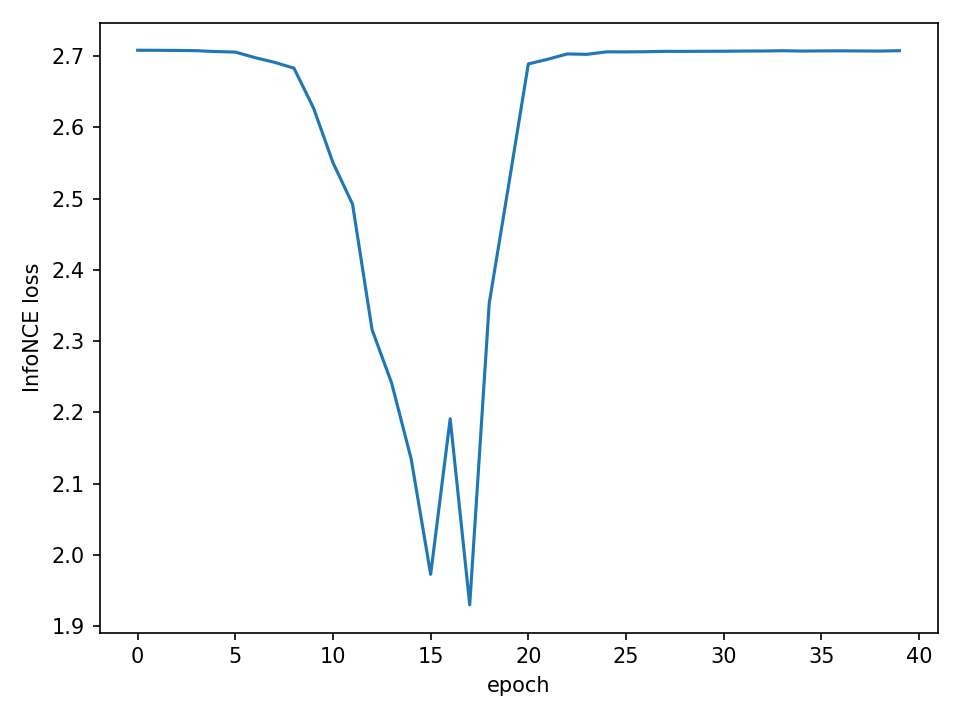

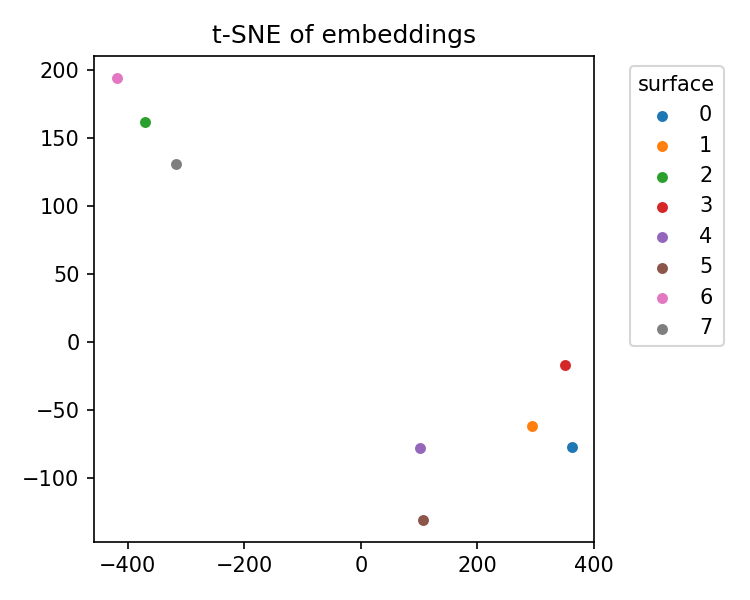

In [ ]:
# show metrics text
!sed -n '1,120p' /content/color_con/outputs/metrics.txt

# display plots
from IPython.display import Image, display
display(Image('/content/color_con/outputs/training_loss.png'))
display(Image('/content/color_con/outputs/tsne.png'))


In [ ]:
%%writefile /content/color_con/src/cc/dataio/synthetic.py
import numpy as np
# robust imports (works whether called as package or script)
try:
    from .spectra import normalize, radiance_from_reflectance_illuminant
except Exception:
    from cc.dataio.spectra import normalize, radiance_from_reflectance_illuminant

class PlanckIlluminant:
    """B(λ,T) = (2hc^2/λ^5) / (exp(hc/(λkT)) - 1); area-normalized."""
    def __init__(self, T: float): self.T = float(T)
    def spd(self, w_nm):
        w = np.asarray(w_nm, float) * 1e-9
        c=2.99792458e8; h=6.62607015e-34; k=1.380649e-23
        L = (2*h*c**2)/(w**5) / (np.exp((h*c)/(w*k*self.T)) - 1.0)
        return normalize(L, "area")

def random_reflectance(w_nm, n_bumps=4, rng=None):
    rng = np.random.default_rng() if rng is None else rng
    w_nm = np.asarray(w_nm, float)
    x = np.zeros_like(w_nm, float)
    for _ in range(n_bumps):
        mu  = rng.uniform(w_nm.min(), w_nm.max())
        sig = rng.uniform(20, 80)
        amp = rng.uniform(0.2, 1.0)
        x  += amp * np.exp(-0.5*((w_nm-mu)/sig)**2)
    x = np.clip(x, 0, None)
    x /= (x.max()+1e-12)
    return x

class SyntheticGenerator:
    """Generate radiances via L(λ)=R(λ)·E(λ), then normalize."""
    def __init__(self, w_nm, norm="area", seed=0):
        self.w_nm = np.asarray(w_nm, float)
        self.norm = norm
        self.rng  = np.random.default_rng(seed)
    def generate(self, n_surfaces=12, n_illuminants=6, T_low=3000, T_high=9500):
        Rs = [random_reflectance(self.w_nm, rng=self.rng) for _ in range(n_surfaces)]
        Ts = self.rng.uniform(T_low, T_high, size=n_illuminants)
        Es = [PlanckIlluminant(float(T)).spd(self.w_nm) for T in Ts]
        X, y = [], []
        for i,R in enumerate(Rs):
            for E in Es:
                L = radiance_from_reflectance_illuminant(R, E)
                X.append(normalize(L, self.norm)); y.append(i)
        return np.stack(X).astype("float32"), np.array(y, int)


Overwriting /content/color_con/src/cc/dataio/synthetic.py


In [ ]:
import sys
sys.path.append('/content/color_con/src')
from cc.dataio.synthetic import SyntheticGenerator, PlanckIlluminant
print("synthetic module OK")


synthetic module OK


In [ ]:
!python /content/color_con/scripts/make_synthetic.py --config /content/color_con/configs/default.yaml


saved synthetic → /content/color_con/data/clean/synthetic.npz


In [ ]:
import numpy as np, torch, sys
sys.path.append('/content/color_con/src')

from cc.utils.config import load_config, get_device
from cc.models.encoders import SpectralMLP
from cc.eval.metrics import embed_all, recall_at_k
from cc.dataio.spectra import wavelength_grid

cfg = load_config('/content/color_con/configs/default.yaml')
device = get_device(cfg["train"]["device"])

# load model
in_dim = len(wavelength_grid(**cfg["data"]["wavelengths"]))
model = SpectralMLP(in_dim, hidden=tuple(cfg["model"]["hidden_sizes"]),
                    emb=cfg["model"]["embedding_dim"], proj=cfg["model"]["projection_dim"]).to(device)
model.load_state_dict(torch.load('/content/color_con/outputs/simclr_mlp.pt', map_location=device))

# load synthetic data
dat = np.load(cfg["synthetic"]["out_npz"])
Xsyn, ysyn = dat["X"].astype("float32"), dat["y"].astype(int)

Zsyn = embed_all(model, Xsyn, device)
r5_syn = recall_at_k(Zsyn, ysyn, k=cfg["eval"]["recall_k"])
print(f"SYNTHETIC Recall@{cfg['eval']['recall_k']}: {r5_syn:.3f} over {len(Xsyn)} samples")


SYNTHETIC Recall@5: 0.861 over 72 samples


In [ ]:
%%writefile /content/color_con/src/cc/eval/plots.py
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

def _save(fig, out_path):
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    fig.tight_layout(); fig.savefig(out_path, dpi=150); plt.close(fig)

def plot_overlay(w, curves, labels, out_path, title="Spectra"):
    fig = plt.figure(figsize=(6,4))
    for c,lab in zip(curves, labels):
        plt.plot(w, c, label=lab)
    plt.xlabel("Wavelength (nm)"); plt.ylabel("Radiance (norm)")
    if len(labels) <= 12: plt.legend(loc="best", fontsize=8)
    plt.title(title); _save(fig, out_path)

def plot_augment_demo(w, x, aug, out_path, title="Augmentation demo"):
    x1, x2 = aug(x), aug(x)
    fig = plt.figure(figsize=(6,4))
    plt.plot(w, x,  label="original")
    plt.plot(w, x1, label="aug #1", alpha=0.9)
    plt.plot(w, x2, label="aug #2", alpha=0.9)
    plt.xlabel("Wavelength (nm)"); plt.ylabel("Radiance (norm)")
    plt.legend(loc="best"); plt.title(title); _save(fig, out_path)

def plot_pca(Z, y, out_path, title="PCA of embeddings"):
    p = PCA(n_components=2).fit_transform(Z)
    fig = plt.figure(figsize=(5,4))
    for cls in np.unique(y):
        m = (y==cls); plt.scatter(p[m,0], p[m,1], s=18, label=str(cls))
    plt.legend(title="surface", bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)
    plt.title(title); _save(fig, out_path)

def plot_distance_histograms(Z, y, out_path, title="Cosine distance hist."):
    D = cosine_distances(Z, Z)
    intra = D[y[:,None]==y[None,:]]
    inter = D[y[:,None]!=y[None,:]]
    fig = plt.figure(figsize=(6,4))
    if intra.size: plt.hist(intra.ravel(), bins=25, alpha=0.7, label="intra")
    if inter.size: plt.hist(inter.ravel(), bins=25, alpha=0.7, label="inter")
    plt.xlabel("Cosine distance"); plt.ylabel("Count"); plt.legend()
    plt.title(title); _save(fig, out_path)


Overwriting /content/color_con/src/cc/eval/plots.py


In [ ]:
%%writefile /content/color_con/scripts/visualize_process1.py
from pathlib import Path
import argparse, numpy as np, pandas as pd, torch, sys
sys.path.append(str(Path(__file__).resolve().parents[1] / "src"))

from cc.utils.config import load_config, get_device
from cc.dataio.dataset import CleanedSpectraDataset
from cc.dataio.transforms import SpectralAugment
from cc.dataio.spectra import wavelength_grid
from cc.models.encoders import SpectralMLP
from cc.eval.metrics import embed_all
from cc.eval.plots import plot_overlay, plot_augment_demo, plot_pca, plot_distance_histograms

def main(cfg_path):
    cfg = load_config(cfg_path)
    device = get_device(cfg["train"]["device"])
    out_dir = Path(cfg["eval"]["out_dir"])
    w = wavelength_grid(**cfg["data"]["wavelengths"])

    # load cleaned data
    aug = SpectralAugment(norm_mode=cfg["data"]["normalization"])
    ds  = CleanedSpectraDataset(cfg["data"]["clean_dir"], cfg["data"]["wavelengths"], cfg["data"]["normalization"], aug)

    # 1) Overlay a few cleaned spectra
    idx = list(range(min(8, len(ds))))
    curves = [ds.spectra[i] for i in idx]
    labels = [Path(ds.paths[i]).stem for i in idx]
    plot_overlay(w, curves, labels, out_dir/"clean_overlay.png", title="Cleaned patch spectra")

    # 2) Augmentation demo using the first spectrum
    plot_augment_demo(w, ds.spectra[0], aug, out_dir/"augment_demo.png")

    # 3) Embedding PCA + 4) distance histograms
    in_dim = len(w)
    model = SpectralMLP(in_dim, hidden=tuple(cfg["model"]["hidden_sizes"]),
                        emb=cfg["model"]["embedding_dim"], proj=cfg["model"]["projection_dim"]).to(device)
    model.load_state_dict(torch.load(out_dir/"simclr_mlp.pt", map_location=device))
    Z = embed_all(model, ds.spectra.astype("float32"), device)
    plot_pca(Z, ds.y, out_dir/"embedding_pca.png")
    plot_distance_histograms(Z, ds.y, out_dir/"distance_hist.png")

    print("Saved figures to", out_dir)

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--config", default="/content/color_con/configs/default.yaml")
    args = ap.parse_args(); main(args.config)


Overwriting /content/color_con/scripts/visualize_process1.py


In [ ]:
!python /content/color_con/scripts/visualize_process1.py --config /content/color_con/configs/default.yaml
!ls -l /content/color_con/outputs | grep -E "overlay|augment|pca|distance"


Saved figures to /content/color_con/outputs
-rw------- 1 root root 103773 Oct  4 11:38 augment_demo.png
-rw------- 1 root root 108544 Oct  4 11:38 clean_overlay.png
-rw------- 1 root root  22861 Oct  4 11:38 distance_hist.png
-rw------- 1 root root  27385 Oct  4 11:38 embedding_pca.png


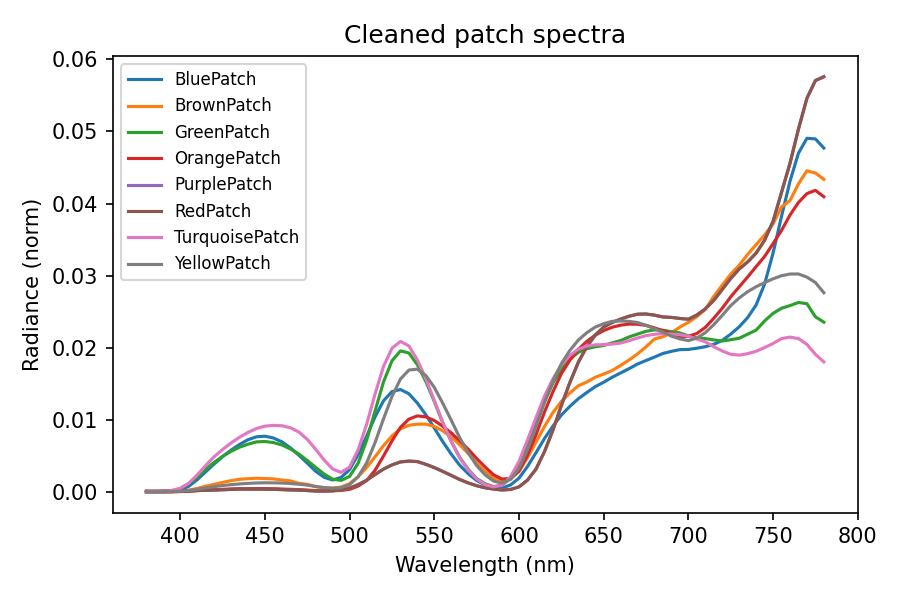

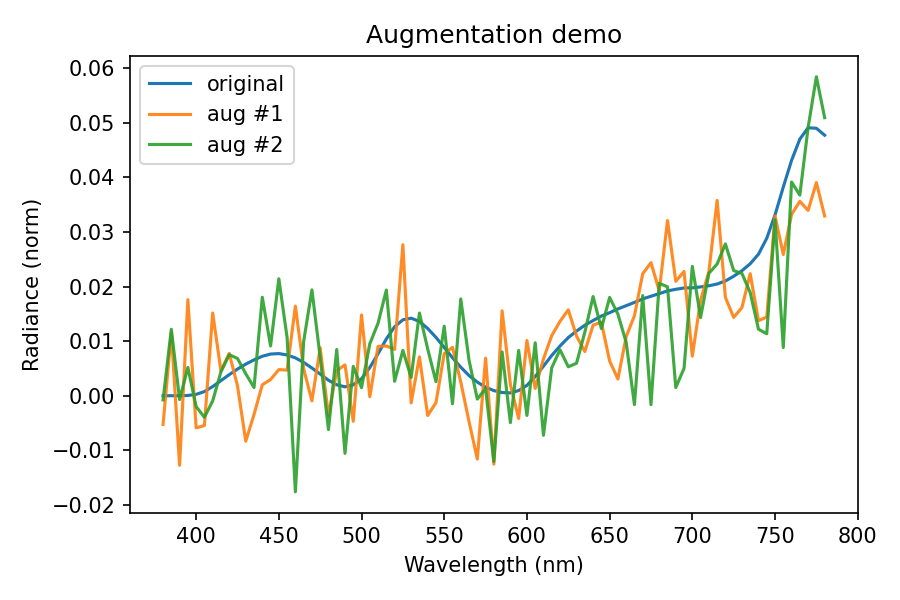

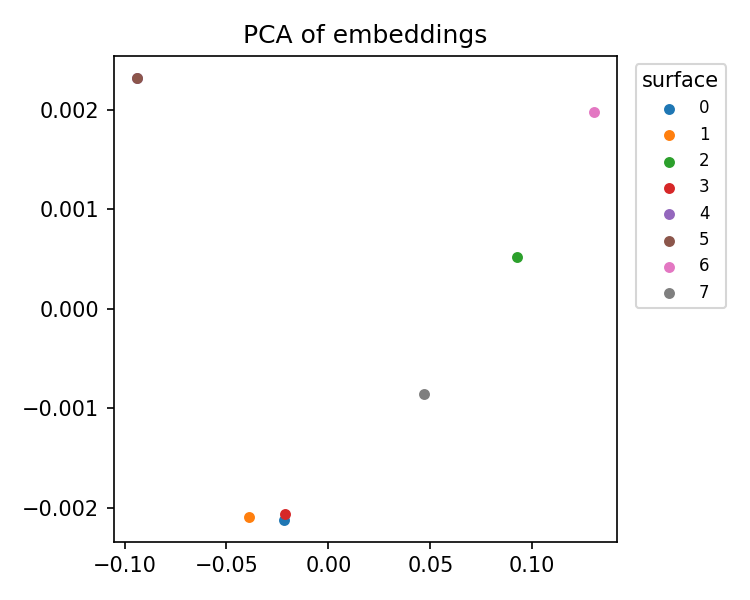

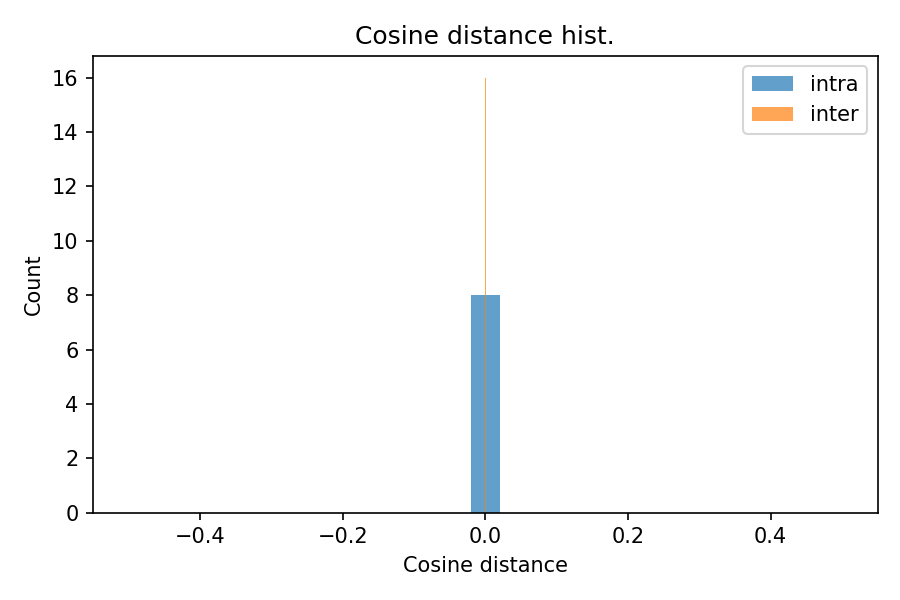

In [ ]:
from IPython.display import Image, display
display(Image('/content/color_con/outputs/clean_overlay.png'))
display(Image('/content/color_con/outputs/augment_demo.png'))
display(Image('/content/color_con/outputs/embedding_pca.png'))
display(Image('/content/color_con/outputs/distance_hist.png'))


In [ ]:
%%writefile /content/color_con/src/cc/eval/plots.py
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

def _save(fig, out_path):
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    fig.tight_layout(); fig.savefig(out_path, dpi=150); plt.close(fig)

def plot_overlay(w, curves, labels, out_path, title="Spectra"):
    fig = plt.figure(figsize=(6,4))
    for c,lab in zip(curves, labels):
        plt.plot(w, c, label=lab)
    plt.xlabel("Wavelength (nm)"); plt.ylabel("Radiance (norm)")
    if len(labels) <= 12: plt.legend(loc="best", fontsize=8)
    plt.title(title); _save(fig, out_path)

def plot_augment_demo(w, x, aug, out_path, title="Augmentation demo"):
    x1, x2 = aug(x), aug(x)
    fig = plt.figure(figsize=(6,4))
    plt.plot(w, x,  label="original")
    plt.plot(w, x1, label="aug #1", alpha=0.9)
    plt.plot(w, x2, label="aug #2", alpha=0.9)
    plt.xlabel("Wavelength (nm)"); plt.ylabel("Radiance (norm)")
    plt.legend(loc="best"); plt.title(title); _save(fig, out_path)

def plot_pca(Z, y, out_path, title="PCA of embeddings"):
    p = PCA(n_components=2).fit_transform(Z)
    fig = plt.figure(figsize=(5,4))
    for cls in np.unique(y):
        m = (y==cls); plt.scatter(p[m,0], p[m,1], s=18, label=str(cls))
    plt.legend(title="surface", bbox_to_anchor=(1.02,1), loc="upper left", fontsize=8)
    plt.title(title); _save(fig, out_path)

def plot_distance_histograms(Z, y, out_path, title="Cosine distance hist."):
    D = cosine_distances(Z, Z)
    intra = D[y[:,None]==y[None,:]]
    inter = D[y[:,None]!=y[None,:]]
    fig = plt.figure(figsize=(6,4))
    if intra.size: plt.hist(intra.ravel(), bins=25, alpha=0.7, label="intra")
    if inter.size: plt.hist(inter.ravel(), bins=25, alpha=0.7, label="inter")
    plt.xlabel("Cosine distance"); plt.ylabel("Count"); plt.legend()
    plt.title(title); _save(fig, out_path)

# NEW: recall curve
def plot_recall_curve(Ks, recalls, out_path, title="Recall@K"):
    fig = plt.figure(figsize=(5,4))
    plt.plot(Ks, recalls, marker="o")
    plt.xlabel("K"); plt.ylabel("Recall@K"); plt.ylim(0,1.0)
    plt.grid(True, alpha=0.3); plt.title(title); _save(fig, out_path)

# NEW: similarity heatmap for one batch
def plot_similarity_heatmap(S, out_path, title="Batch similarity (cos/τ)"):
    fig = plt.figure(figsize=(4.8,4.4))
    im = plt.imshow(S, aspect="equal")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title(title); plt.xlabel("index"); plt.ylabel("index")
    _save(fig, out_path)


Overwriting /content/color_con/src/cc/eval/plots.py


In [ ]:
%%writefile /content/color_con/scripts/visualize_more.py
from pathlib import Path
import argparse, numpy as np, torch, sys
sys.path.append(str(Path(__file__).resolve().parents[1] / "src"))

from cc.utils.config import load_config, get_device
from cc.dataio.transforms import SpectralAugment
from cc.dataio.dataset import CleanedSpectraDataset
from cc.dataio.spectra import wavelength_grid
from cc.dataio.synthetic import PlanckIlluminant, random_reflectance
from cc.models.encoders import SpectralMLP
from cc.eval.metrics import embed_all, recall_at_k
from cc.eval.plots import plot_overlay, plot_recall_curve, plot_similarity_heatmap

def main(cfg_path):
    cfg = load_config(cfg_path); out = Path(cfg["eval"]["out_dir"])
    device = get_device(cfg["train"]["device"])
    w = wavelength_grid(**cfg["data"]["wavelengths"])

    # === (A) Physics visuals: Planck SPDs + random reflectances ===
    Ts = np.linspace(cfg["synthetic"]["planck_T_range"][0],
                     cfg["synthetic"]["planck_T_range"][1], 5)
    spds   = [PlanckIlluminant(float(T)).spd(w) for T in Ts]
    labels = [f"{int(T)} K" for T in Ts]
    plot_overlay(w, spds, labels, out/"synthetic_spds.png", title="Planck illuminants (area-norm)")

    Rs = [random_reflectance(w, rng=np.random.default_rng(i)) for i in range(5)]
    plot_overlay(w, Rs, [f"R#{i+1}" for i in range(5)], out/"synthetic_reflectances.png", title="Random reflectances")

    # === (B) Recall@K curve on synthetic set ===
    dat = np.load(cfg["synthetic"]["out_npz"])
    Xsyn, ysyn = dat["X"].astype("float32"), dat["y"].astype(int)

    in_dim = len(w)
    model = SpectralMLP(in_dim, hidden=tuple(cfg["model"]["hidden_sizes"]),
                        emb=cfg["model"]["embedding_dim"], proj=cfg["model"]["projection_dim"]).to(device)
    model.load_state_dict(torch.load(out/"simclr_mlp.pt", map_location=device))

    Zsyn = embed_all(model, Xsyn, device)
    Ks = [1,2,3,4,5,7,10] if len(Xsyn) >= 11 else list(range(1, min(6, len(Xsyn))))
    recalls = [recall_at_k(Zsyn, ysyn, k=k) for k in Ks]
    plot_recall_curve(Ks, recalls, out/"recall_curve.png")

    # === (C) InfoNCE batch similarity heatmap (on cleaned patch set) ===
    aug = SpectralAugment(norm_mode=cfg["data"]["normalization"])
    ds  = CleanedSpectraDataset(cfg["data"]["clean_dir"], cfg["data"]["wavelengths"], cfg["data"]["normalization"], aug)
    bs  = min(8, len(ds))
    x1, x2, _ = zip(*[ds[i] for i in range(bs)])
    x1 = torch.stack(list(x1)).to(device).float()
    x2 = torch.stack(list(x2)).to(device).float()
    _, p1 = model(x1); _, p2 = model(x2)
    Z = torch.cat([p1, p2], dim=0)
    S = (Z @ Z.t()).detach().cpu().numpy() / float(cfg["train"]["temperature"])
    plot_similarity_heatmap(S, out/"similarity_heatmap.png")

    print("Saved:",
          out/"synthetic_spds.png", ",",
          out/"synthetic_reflectances.png", ",",
          out/"recall_curve.png", ",",
          out/"similarity_heatmap.png")

if __name__ == "__main__":
    ap = argparse.ArgumentParser()
    ap.add_argument("--config", default="/content/color_con/configs/default.yaml")
    args = ap.parse_args(); main(args.config)


Overwriting /content/color_con/scripts/visualize_more.py


In [ ]:
!python /content/color_con/scripts/visualize_more.py --config /content/color_con/configs/default.yaml
!ls -l /content/color_con/outputs | grep -E "synthetic_|recall_curve|similarity_heatmap"


Saved: /content/color_con/outputs/synthetic_spds.png , /content/color_con/outputs/synthetic_reflectances.png , /content/color_con/outputs/recall_curve.png , /content/color_con/outputs/similarity_heatmap.png
-rw------- 1 root root  21830 Oct  4 11:38 recall_curve.png
-rw------- 1 root root  40111 Oct  4 11:38 similarity_heatmap.png
-rw------- 1 root root 104199 Oct  4 11:38 synthetic_reflectances.png
-rw------- 1 root root  78513 Oct  4 11:38 synthetic_spds.png


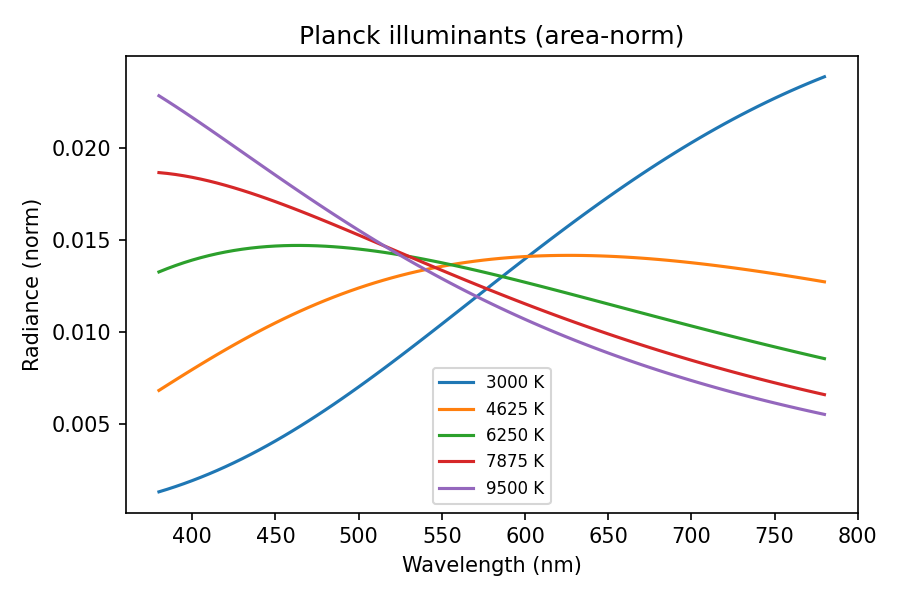

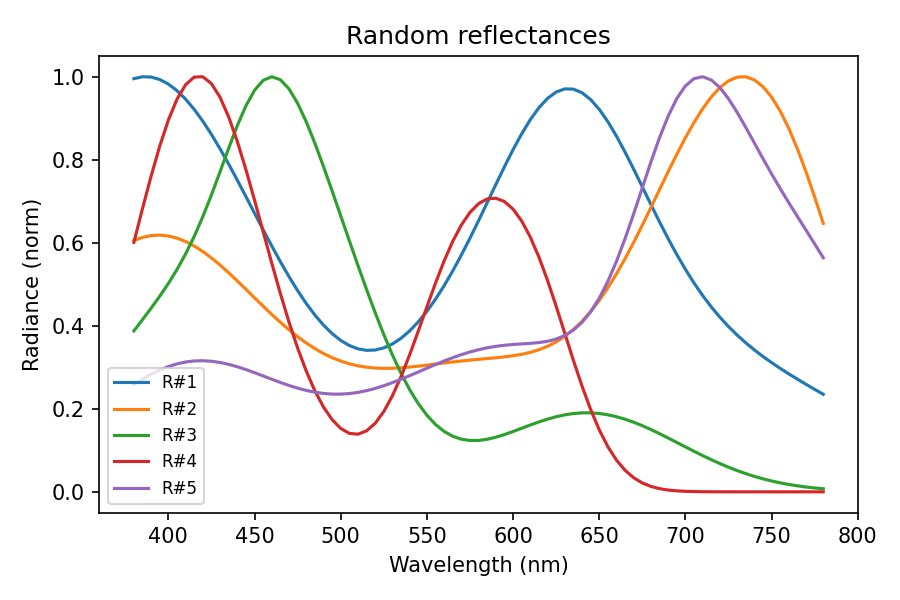

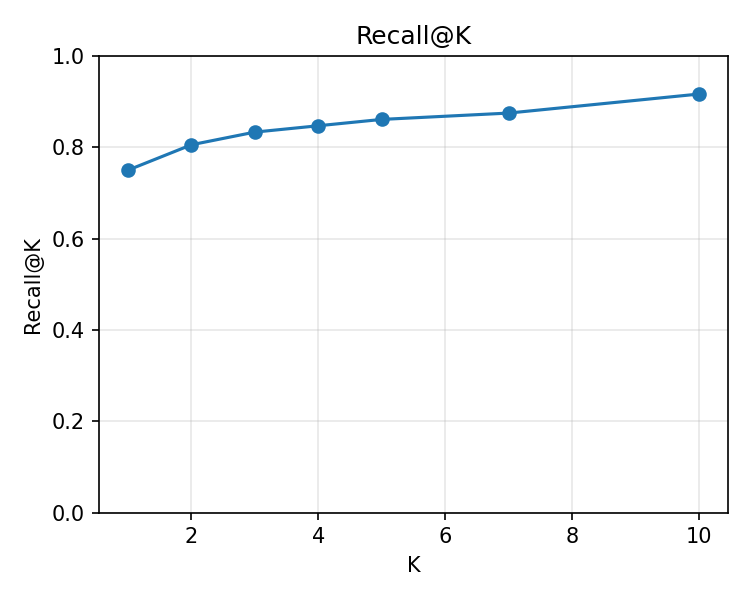

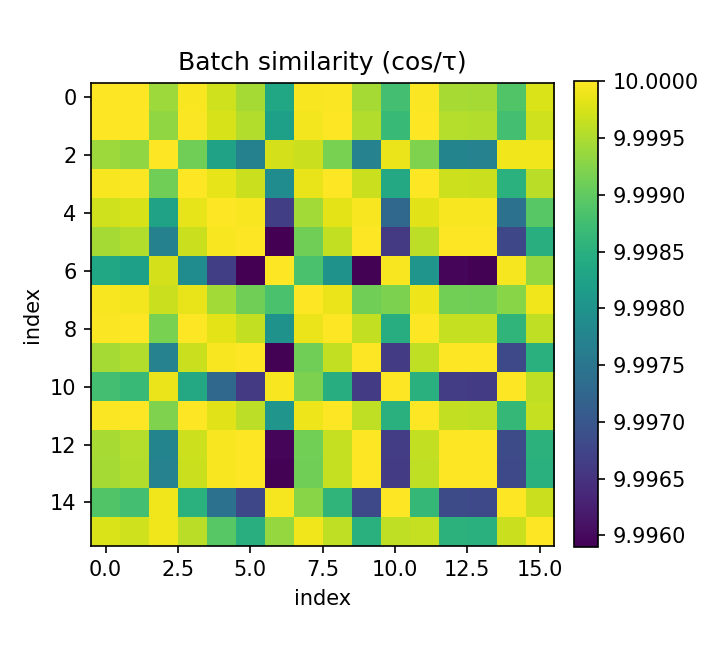

In [ ]:
from IPython.display import Image, display
display(Image('/content/color_con/outputs/synthetic_spds.png'))
display(Image('/content/color_con/outputs/synthetic_reflectances.png'))
display(Image('/content/color_con/outputs/recall_curve.png'))
display(Image('/content/color_con/outputs/similarity_heatmap.png'))


In [ ]:
%%bash
cd /content
zip -r -q color_con_project.zip color_con
ls -lh color_con_project.zip


-rw-r--r-- 1 root root 1.2M Oct  4 11:38 color_con_project.zip
